In [1]:
# Install required packages (if needed)
%pip install -q torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.9 MB/s eta 0:00:00


In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Basic setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Transform: Normalize images to [0, 1] and flatten them
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Standard MNIST normalization
])

# Download and load data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# For speed: use a smaller subset
train_dataset, _ = random_split(train_dataset, [10000, len(train_dataset) - 10000])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1000)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.87MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.21MB/s]


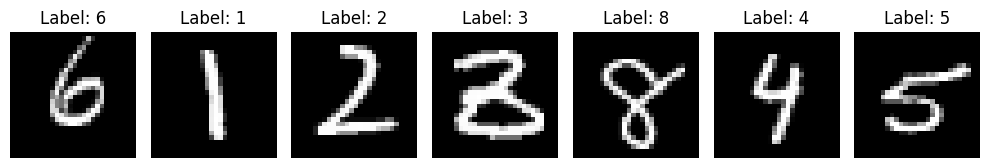

In [6]:
import matplotlib.pyplot as plt

# Get a batch of images
examples = next(iter(train_loader))
images, labels = examples

# Plot the first 6 images
plt.figure(figsize=(10, 2))
for i in range(7):
    plt.subplot(1, 7, i + 1)
    plt.imshow(images[i][0], cmap="gray")
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
# Teacher: bigger model
class TeacherNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 1200)
        self.fc2 = nn.Linear(1200, 600)
        self.fc3 = nn.Linear(600, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Student: smaller model
class StudentNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [8]:
def train_teacher(model, train_loader, epochs=5, lr=1e-3):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")
    return model

# Instantiate and train teacher
teacher_model = TeacherNet()
teacher_model = train_teacher(teacher_model, train_loader)

Epoch 1/5, Loss: 62.8367
Epoch 2/5, Loss: 23.4720
Epoch 3/5, Loss: 16.1862
Epoch 4/5, Loss: 11.2762
Epoch 5/5, Loss: 8.4171


In [9]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    acc = 100.0 * correct / total
    print(f"Accuracy: {acc:.2f}%")
    return acc

# Evaluate teacher model
evaluate(teacher_model, test_loader)

Accuracy: 95.35%


95.35

In [10]:
def train_student_hard(student_model, train_loader, epochs=5, lr=1e-3):
    student_model.to(device)
    optimizer = optim.Adam(student_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    student_model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = student_model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")
    return student_model

# Train the student model (hard labels only)
student_hard = StudentNet()
student_hard = train_student_hard(student_hard, train_loader)

Epoch 1/5, Loss: 82.2910
Epoch 2/5, Loss: 34.8895
Epoch 3/5, Loss: 22.3143
Epoch 4/5, Loss: 15.4817
Epoch 5/5, Loss: 9.4693


In [11]:
# Evaluate student trained on hard labels
evaluate(student_hard, test_loader)

Accuracy: 95.45%


95.45

In [13]:
def distillation_loss(student_logits, teacher_logits, temperature):
    """
    Computes the soft loss: KL Divergence between teacher and student logits.
    """
    T = temperature
    student_probs = F.log_softmax(student_logits / T, dim=1)
    teacher_probs = F.softmax(teacher_logits / T, dim=1)
    return F.kl_div(student_probs, teacher_probs, reduction="batchmean") * (T ** 2)

def train_student_distilled(student_model, teacher_model, train_loader, epochs=5, lr=1e-3, temperature=5.0, alpha=0.5):
    student_model.to(device)
    teacher_model.to(device)
    teacher_model.eval()

    optimizer = optim.Adam(student_model.parameters(), lr=lr)
    ce_loss = nn.CrossEntropyLoss()

    student_model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            with torch.no_grad():
                teacher_logits = teacher_model(x)

            student_logits = student_model(x)

            loss_soft = distillation_loss(student_logits, teacher_logits, temperature)
            loss_hard = ce_loss(student_logits, y)

            loss = alpha * loss_soft + (1 - alpha) * loss_hard
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Distilled Loss: {total_loss:.4f}")

    return student_model

# Train student with distillation
student_distilled = StudentNet()
student_distilled = train_student_distilled(student_distilled, teacher_model, train_loader)

Epoch 1/5, Distilled Loss: 553.7055
Epoch 2/5, Distilled Loss: 131.1812
Epoch 3/5, Distilled Loss: 65.5557
Epoch 4/5, Distilled Loss: 42.6676
Epoch 5/5, Distilled Loss: 28.3162


In [14]:
# Evaluate student trained with distillation
evaluate(student_distilled, test_loader)

Accuracy: 94.97%


94.97

In [15]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Teacher params:  {count_params(teacher_model):,}")
print(f"Student (hard) params:  {count_params(student_hard):,}")
print(f"Student (distilled) params:  {count_params(student_distilled):,}")

Teacher params:  1,668,610
Student (hard) params:  266,610
Student (distilled) params:  266,610


# 🧪 Knowledge Distillation on MNIST: Hands-on Demo

This notebook demonstrates **Knowledge Distillation**, a technique to train a smaller neural network (student) by learning from a larger, well-trained model (teacher).

---

## 📌 Objective

- Compare three models on the MNIST digit classification task:
  - A **Teacher** model (large)
  - A **Student** trained with **hard labels** (baseline)
  - A **Student** trained via **Knowledge Distillation** (soft labels)

---

## 📊 Experiment Setup

- Dataset: 10k samples from MNIST (for speed)
- Input: 28×28 grayscale digit images
- Framework: PyTorch

### Models:

| Model   | Architecture | Param Count |
|---------|--------------|-------------|
| Teacher | 784 → 1200 → 600 → 10 | 1.67M |
| Student | 784 → 300 → 100 → 10 | 266k |

---

## ⚙️ Training Overview

- **Teacher**: Trained on ground truth with CrossEntropyLoss
- **Hard-label Student**: Same loss, smaller model
- **Distilled Student**:
  - Trained on a **blend of soft labels (KL-Divergence)** and hard labels
  - Temperature = 5.0
  - Alpha (soft/hard loss mix) = 0.5

---

## 📈 Results

| Model                | Params     | Accuracy  |
|---------------------|------------|-----------|
| **Teacher**          | 1,668,610  | **95.35%** |
| **Student (hard)**   | 266,610    | **95.45%** |
| **Student (distilled)** | 266,610    | **94.97%** |

---

## 🧠 Observations

- The **student (hard)** surprisingly matched or slightly outperformed the teacher.
- The **distilled student** performed slightly worse, possibly due to:
  - Small dataset
  - Suboptimal temperature or alpha
- Distillation gains are more pronounced on complex tasks or larger datasets.

---

## ✅ Key Learnings

- Distillation transfers *soft knowledge* — not just correct answers, but *probabilities over alternatives*.
- Works best when:
  - Teacher is significantly stronger than student
  - Task is complex enough to benefit from richer supervision
- A distilled model retains teacher-like performance while being lightweight.
